In [28]:
!pip install kaggle

In [29]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"irgisetiawan","key":"16edb3ba20db82083f13eb3858670b31"}'}

In [30]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [31]:
!kaggle datasets download -d hasibalmuzdadid/shoe-vs-sandal-vs-boot-dataset-15k-images

Dataset URL: https://www.kaggle.com/datasets/hasibalmuzdadid/shoe-vs-sandal-vs-boot-dataset-15k-images
License(s): copyright-authors
shoe-vs-sandal-vs-boot-dataset-15k-images.zip: Skipping, found more recently modified local copy (use --force to force download)


In [32]:
!unzip shoe-vs-sandal-vs-boot-dataset-15k-images.zip

Streaming output truncated to the last 5000 lines.
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (10).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (100).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1000).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1001).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1002).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1003).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1004).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1005).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1006).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1007).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1008).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1009).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (101).jpg  
  inflating: Shoe 

In [33]:
!pip install tensorflowjs

import numpy as np
import pandas as pd
import random
import shutil
import os
from tqdm.notebook import tqdm as tq

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
import tensorflowjs as tfjs
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [34]:
footwear_path = 'Shoe vs Sandal vs Boot Dataset/'

file_names = []
labels = []
full_paths = []

for path, subdirs, files in os.walk(footwear_path):
  for name in files:
    full_paths.append(os.path.join(path, name))
    labels.append(path.split('/')[-1])
    file_names.append(name)

In [35]:
df = pd.DataFrame({"path":full_paths, "filename":file_names, "labels":labels})

In [36]:
X = df['path']
y = df['labels']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=300)

In [37]:
df_train = pd.DataFrame({'path':X_train,'labels':y_train,'set':'train'})
df_test = pd.DataFrame({'path':X_test,'labels':y_test,'set':'test'})
df_all = pd.concat([df_train, df_test], ignore_index=True)

input_path = "Shoe vs Sandal vs Boot Dataset/"
output_path="footwear_ds/"

In [38]:
for index, row in tq(df_all.iterrows()):
  file_path = row['path']
  if os.path.exists(file_path) == False:
    file_path = os.path.join(input_path, row['labels'], row['image'].split('.')[0])

  if os.path.exists(os.path.join(output_path, row['set'], row['labels'])) == False:
    os.makedirs(os.path.join(output_path, row['set'], row['labels']))

  destination_file_name = file_path.split('/')[-1]
  file_dest = os.path.join(output_path, row['set'], row['labels'], destination_file_name)

  if os.path.exists(file_dest) == False:
    shutil.copy2(file_path, file_dest)

0it [00:00, ?it/s]

In [39]:
TRAIN_DIR = "footwear_ds/train/"
TEST_DIR = "footwear_ds/test/"

In [40]:
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    TRAIN_DIR,
    batch_size=32,
    target_size=(102,136),
    color_mode="rgb",
    class_mode='categorical',
    shuffle=True
    )

validation_generator = datagen.flow_from_directory(
    TEST_DIR,
    batch_size=32,
    target_size=(102,136),
    color_mode="rgb",
    class_mode='categorical',
    shuffle=False
    )

Found 12000 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.


In [41]:
model = Sequential([
    Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(102, 136, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Conv2D(32, (4, 4), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Conv2D(32, (7, 7), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

model.compile(optimizer=RMSprop(),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [42]:
checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001)

In [43]:
history = model.fit(train_generator,
                    epochs=30,
                    batch_size=32,
                    validation_data=validation_generator,
                    callbacks=[checkpoint, early_stopping, reduce_lr])

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


375/375 ━━━━━━━━━━━━━━━━━━━━ 31s 54ms/step - accuracy: 0.7082 - loss: 1.0728 - val_accuracy: 0.9093 - val_loss: 0.2691 - learning_rate: 0.0010
Epoch 2/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - accuracy: 0.9200 - loss: 0.2898 - val_accuracy: 0.8850 - val_loss: 0.4068 - learning_rate: 0.0010
Epoch 3/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - accuracy: 0.9468 - loss: 0.1714 - val_accuracy: 0.9417 - val_loss: 0.1574 - learning_rate: 0.0010
Epoch 4/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - accuracy: 0.9634 - loss: 0.1271 - val_accuracy: 0.9350 - val_loss: 0.1920 - learning_rate: 0.0010
Epoch 5/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - accuracy: 0.9697 - loss: 0.1097 - val_accuracy: 0.9440 - val_loss: 0.3955 - learning_rate: 0.0010
Epoch 6/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 22s 34ms/step - accuracy: 0.9754 - loss: 0.0840 - val_accuracy: 0.9587 - val_loss: 0.1638 - learning_rate: 0.0010


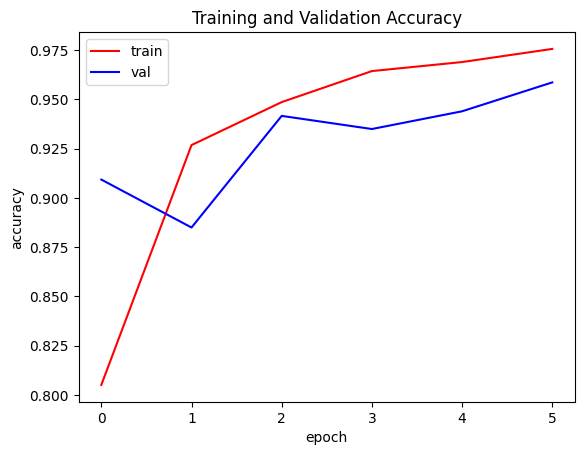

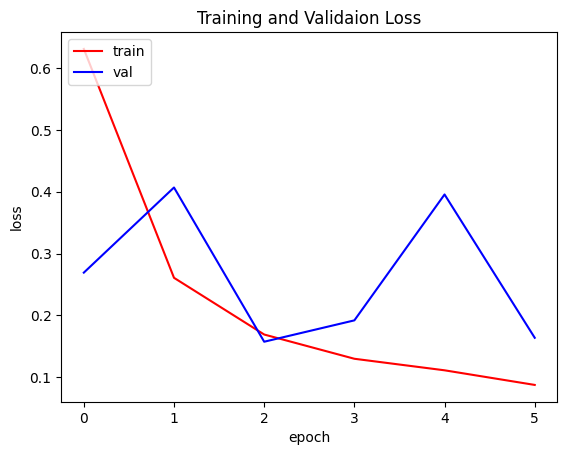

In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()

In [45]:
save_path = 'footwear_model_savedmodel/'
tf.saved_model.save(model, save_path)

In [46]:
saved_model_dir = "footwear_model.keras"
model.save(saved_model_dir)

In [47]:
keras_model_path = "/content/footwear_model.keras"
keras_model = tf.keras.models.load_model(keras_model_path)

In [48]:
converter = tf.lite.TFLiteConverter.from_keras_model(keras_model)
tflite_model = converter.convert()

tflite_model_path = 'footwear_model_tflite/model.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmp0zy3ijdf'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 102, 136, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  132299453450544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132296537595520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132296536994416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132296536981920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132296698444112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132296536988608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132294503239520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132296537686784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132296537691888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132296537698928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1322965376869

In [49]:
tfjs_model_dir = 'footwear_model_tfjs/tfjs_model/'
tfjs.converters.save_keras_model(keras_model, tfjs_model_dir)

failed to lookup keras version from the file,
    this is likely a weight only file


In [50]:
!zip -r tfjs_model.zip /content/footwear_model_tfjs/tfjs_model

updating: content/footwear_model_tfjs/tfjs_model/ (stored 0%)
updating: content/footwear_model_tfjs/tfjs_model/group1-shard1of1.bin (deflated 7%)
updating: content/footwear_model_tfjs/tfjs_model/model.json (deflated 88%)


In [51]:
!zip -r tflite.zip /content/footwear_model_tflite

updating: content/footwear_model_tflite/ (stored 0%)
updating: content/footwear_model_tflite/model.tflite (deflated 7%)


In [52]:
!zip -r saved_model.zip /content/footwear_model_savedmodel

updating: content/footwear_model_savedmodel/ (stored 0%)
updating: content/footwear_model_savedmodel/variables/ (stored 0%)
updating: content/footwear_model_savedmodel/variables/variables.index (deflated 66%)
updating: content/footwear_model_savedmodel/variables/variables.data-00000-of-00001 (deflated 11%)
updating: content/footwear_model_savedmodel/fingerprint.pb (stored 0%)
updating: content/footwear_model_savedmodel/assets/ (stored 0%)
updating: content/footwear_model_savedmodel/saved_model.pb (deflated 88%)
